<a href="https://colab.research.google.com/github/angelms2003/FernandezMartinezPolo-EML-RL/blob/main/k_brazos/UCB_bernoulli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estudio comparativo de algoritmos en un problema de k-armed bandit

*Description:* El experimento compara el rendimiento de algoritmos epsilon-greedy en un problema de k-armed bandit.
Se generan gráficas de recompensas promedio para cada algoritmo.

    Authors: David Fernández Expósito
             Ángel Martínez Sánchez
             Javier Polo Gambín
    Emails: dfernandezexposito@um.es
            angel.martinezs@um.es
            javier.polog@um.es
    Date: 2026/02/14

This software is licensed under the GNU General Public License v3.0 (GPL-3.0),
with the additional restriction that it may not be used for commercial purposes.

For more details about GPL-3.0: https://www.gnu.org/licenses/gpl-3.0.html



## Preparación del entorno


Primero copiamos nuestro repositorio.

In [1]:
!git clone https://github.com/angelms2003/FernandezMartinezPolo-EML-RL.git


Cloning into 'FernandezMartinezPolo-EML-RL'...
remote: Enumerating objects: 144, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 144 (delta 80), reused 109 (delta 45), pack-reused 0 (from 0)
Receiving objects: 100% (144/144), 892.71 KiB | 2.05 MiB/s, done.
Resolving deltas: 100% (80/80), done.


In [2]:
!cd FernandezMartinezPolo-EML-RL/

In [3]:
#@title Importamos todas las clases y funciones

import sys

# Añadir los directorio fuentes al path de Python
sys.path.append('/content/FernandezMartinezPolo-EML-RL/k_brazos/src')


# Verificar que se han añadido correctamente
print(sys.path)

import numpy as np
from typing import List

from algorithms import Algorithm, EpsilonGreedy, EpsilonDecay, UCB1, UCB2
from arms import ArmBernoulli, Bandit
from plotting import plot_average_rewards, plot_optimal_selections, plot_regret


['/content', '/env/python', '/usr/lib/python312.zip', '/usr/lib/python3.12', '/usr/lib/python3.12/lib-dynload', '', '/usr/local/lib/python3.12/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.12/dist-packages/IPython/extensions', '/root/.ipython', '/content/FernandezMartinezPolo-EML-RL/k_brazos/src']


## Experimento

En este notebook se analiza un problema de bandido multi-brazo de 10 brazos, donde cada brazo sigue una distribución de Bernoulli. Se implementan dos variantes del algoritmo UCB1 y dos variantes del algoritmo UCB2, utilizando distintos valores de los parámetros (c) y (\alpha).

Cada política se evalúa a lo largo de 2000 iteraciones, y todo el experimento se repite 500 veces de forma independiente. En cada iteración se calcula la media de las recompensas obtenidas considerando esas 500 ejecuciones.

La razón por la que se usan 2000 iteraciones, mientras que en los experimentos con los demás algoritmos fueron menos de forma general es que estos algoritmos requieren un horizonte temporal mayor para mostrar su comportamiento asintótico. En particular, el término de exploración depende logarítmicamente del número total de pasos, por lo que con más iteraciones se obtiene una estimación más estable del arrepentimiento y de la convergencia hacia el brazo óptimo.

La comparación entre algoritmos se realiza utilizando varias métricas: recompensa media, proporción media de selecciones óptimas, arrepentimiento acumulado medio, así como la ganancia media y el número medio de selecciones realizadas en cada brazo.


In [12]:

def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):

    optimal_arm = bandit.optimal_arm  # Necesario para calcular el porcentaje de selecciones óptimas.

    rewards = np.zeros((len(algorithms), steps)) # Matriz para almacenar las recompensas promedio.

    regrets = np.zeros((len(algorithms), steps)) # Matriz para almacenar los rechazos promedio.

    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para almacenar el porcentaje de selecciones óptimas.

    np.random.seed(seed)  # Asegurar reproducibilidad de resultados.

    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms)

        for algo in algorithms:
            algo.reset() # Reiniciar los valores de los algoritmos.

        total_rewards_per_algo = np.zeros(len(algorithms)) # Acumulador de recompensas por algoritmo. Necesario para calcular el promedio.

        sum_current_run_expected_value = np.zeros(len(algorithms)) # Aquí se almacena el valor esperado acumulado para cada algoritmo de esta run. Necesario para calcular el rechazo

        for idx, algo in enumerate(algorithms):
          for step in range(steps):
                chosen_arm = algo.select_arm() # Seleccionar un brazo según la política del algoritmo.
                reward = current_bandit.pull_arm(chosen_arm) # Obtener la recompensa del brazo seleccionado.
                algo.update(chosen_arm, reward) # Actualizar el valor estimado del brazo seleccionado.

                rewards[idx, step] += reward # Acumular la recompensa obtenida en la matriz rewards para el algoritmo idx en el paso step.
                total_rewards_per_algo[idx] += reward # Acumular la recompensa obtenida en total_rewards_per_algo para el algoritmo idx.

                # Modificar optimal_selections cuando el brazo elegido se corresponde con el brazo óptimo optimal_arm
                if chosen_arm == optimal_arm:
                    optimal_selections[idx, step] += 1

                # Si el step actual es 0, el valor esperado acumulado se inicializa con el valor esperado del brazo
                # elegido actualmente. Si no, se suma el valor esperado del brazo actual al valor acumulado
                if step == 0:
                    sum_current_run_expected_value[idx] = bandit.get_expected_value(chosen_arm)
                else:
                    sum_current_run_expected_value[idx] = sum_current_run_expected_value[idx] + bandit.get_expected_value(chosen_arm)

                regrets[idx, step] = regrets[idx, step-1] + (bandit.get_expected_value(optimal_arm) - reward) if step > 0 else bandit.get_expected_value(optimal_arm) - reward
                #regrets[idx, step] += (step+1)*bandit.get_expected_value(optimal_arm) - sum_current_run_expected_value[idx]

    rewards /= runs
    regrets /= runs

    # Calcular el porcentaje de selecciones óptimas
    optimal_selections = optimal_selections*100/runs

    return rewards, regrets, optimal_selections


## Ejecución del experimento

Se diseña un experimento sobre un problema de bandido multi-brazo con 10 acciones posibles, donde las recompensas asociadas a cada brazo siguen una distribución de Bernoulli. Para garantizar la estabilidad estadística de los resultados, el experimento se repite 500 veces, realizando en cada repetición una simulación de 2000 iteraciones. En este contexto se evalúan cuatro configuraciones diferentes de algoritmos basados en UCB: dos variantes de UCB1 y dos variantes de UCB2.

A diferencia de estrategias como $\varepsilon$-Greedy, donde en cada paso se elige una acción aleatoria con probabilidad $\varepsilon$ y, en caso contrario, se selecciona la acción con mayor recompensa media estimada, los algoritmos UCB siguen un criterio basado en el límite superior de confianza. En cada iteración se selecciona la acción que maximiza:

$$
ucb(a) = Q(a) + u(a)
$$

donde $Q(a)$ representa la estimación actual de la recompensa media de la acción $a$, y $u(a)$ es un término que fomenta la exploración de acciones menos utilizadas.

En el algoritmo UCB1, el término de exploración se define como:

$$
u(a) = c \sqrt{\frac{\log t}{N(a)}}
$$

donde $c$ es un parámetro que regula la intensidad de la exploración, $t$ es el número total de iteraciones realizadas y $N(a)$ es el número de veces que se ha seleccionado la acción $a$.

Por su parte, UCB2 introduce un mecanismo basado en épocas. En este caso, el término de exploración se calcula como:

$$
u(a) = \sqrt{\frac{(1+\alpha)\log\left(\frac{e \cdot t}{\tau(k_a)}\right)}{2\tau(k_a)}}
$$

donde $\alpha \in (0,1)$ controla el equilibrio entre exploración y explotación, $k_a$ representa el número de épocas asociadas a la acción $a$, y

$$
\tau(k_a) = \lceil (1+\alpha)^{k_a} \rceil
$$

determina la duración de cada época. Cuando se selecciona una acción $a$, esta se ejecuta durante

$$
\lceil \tau(k_a+1) - \tau(k_a) \rceil
$$

iteraciones consecutivas.

En los experimentos realizados se utilizan dos valores del parámetro de exploración en UCB1 ($c = 0.1$ y $c = 1$) y dos valores del parámetro $\alpha$ en UCB2 ($\alpha = 0.3$ y $\alpha = 0.9$), con el objetivo de analizar cómo distintos niveles de exploración afectan al rendimiento de los algoritmos.

In [13]:

# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 2000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmBernoulli.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar.
algorithms = [UCB1(k=k, c=0.1), UCB1(k=k, c=1.0), UCB2(k=k, alpha=0.3), UCB2(k=k, alpha=0.9)]
# Ejecutar el experimento y obtener las recompensas promedio, rechazo acumulado y promedio de las selecciones óptimas
rewards, regrets, optimal_selections = run_experiment(bandit, algorithms, steps, runs)


Bandit with 10 arms: ArmBernoulli(p=0.37), ArmBernoulli(p=0.95), ArmBernoulli(p=0.73), ArmBernoulli(p=0.60), ArmBernoulli(p=0.16), ArmBernoulli(p=0.16), ArmBernoulli(p=0.06), ArmBernoulli(p=0.87), ArmBernoulli(p=0.60), ArmBernoulli(p=0.71)
Optimal arm: 2 with expected reward=0.9507143064099162


## Visualización de los resultados

### Recompensa promedio vs pasos de tiempo

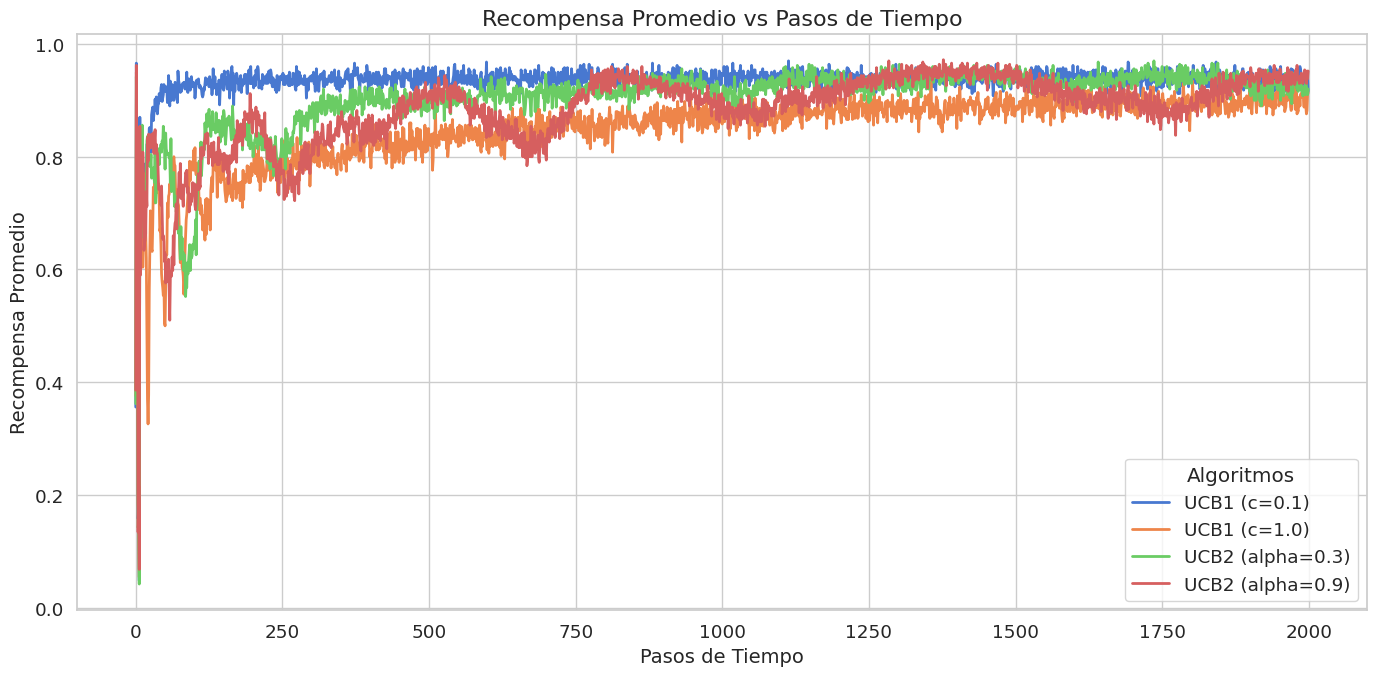

In [14]:

# Graficar los resultados
plot_average_rewards(steps, rewards, algorithms)


**ANÁLISIS DETALLADO DE LA IMAGEN**

La imagen muestra un gráfico de líneas titulado **"Recompensa Promedio vs Pasos de Tiempo"**, donde se compara el comportamiento de distintas configuraciones de los algoritmos **UCB1** y **UCB2**. En el eje **x** aparecen los **pasos de tiempo**, mientras que en el eje **y** se representa la **recompensa promedio** obtenida por cada política a lo largo del proceso de aprendizaje.

**1. Interpretación de las líneas del gráfico**

En la gráfica aparecen cuatro curvas, cada una correspondiente a una configuración distinta de los algoritmos:

- **Azul (UCB1 con $c = 0.1$):** Representa una estrategia con exploración baja (explotadora), donde el algoritmo explora alternativas pero prioriza las acciones que ya han demostrado buen rendimiento.  
- **Naranja (UCB1 con $c = 1.0$):** Representa una estrategia más exploradora, ya que un valor alto de $c$ incrementa el peso del término de exploración.  
- **Verde (UCB2 con $\alpha = 0.3$):** Estrategia con exploración moderada dentro del esquema basado en épocas característico de UCB2.  
- **Roja (UCB2 con $\alpha = 0.9$):** Estrategia altamente exploradora, donde se favorece probar brazos menos seleccionados.


**2. Evolución de la recompensa promedio**

De forma general, todos los algoritmos convergen hacia valores altos de recompensa promedio, situándose aproximadamente alrededor de $0.9$. Esto indica que todos consiguen identificar los mejores brazos conforme aumenta el número de pasos.

No obstante, existen diferencias claras en:

- Velocidad de convergencia inicial  
- Estabilidad de la recompensa  
- Oscilaciones provocadas por la exploración  

**UCB1 ($c = 0.1$) — Línea azul**

Esta configuración presenta el crecimiento más rápido y estable. Tras los primeros pasos, la recompensa promedio aumenta rápidamente hasta valores cercanos al óptimo y se mantiene muy estable durante casi todo el experimento. Esto sugiere que el equilibrio entre exploración y explotación está bien ajustado.

**UCB1 ($c = 1.0$) — Línea naranja**

Esta curva presenta una fase inicial más inestable, con caídas pronunciadas en los primeros pasos. Esto ocurre porque el algoritmo realiza más exploración.

Con el paso del tiempo la recompensa mejora, aunque suele mantenerse ligeramente por debajo del resto. Además, muestra pequeñas oscilaciones constantes, lo que indica que continúa explorando incluso cuando ya dispone de buena información.

**UCB2 ($\alpha = 0.3$) — Línea verde**

Muestra un crecimiento inicial razonablemente rápido, aunque algo más lento que la línea azul. En la fase intermedia aparecen pequeñas oscilaciones, probablemente relacionadas con el cambio entre épocas del algoritmo.

Finalmente converge a valores cercanos a los mejores resultados, aunque normalmente queda ligeramente por debajo del mejor rendimiento observado.

**UCB2 ($\alpha = 0.9$) — Línea roja**

Es la curva más inestable al inicio. Se observan caídas muy pronunciadas en los primeros pasos, lo que indica exploración agresiva y selección frecuente de brazos con baja recompensa.

Conforme aumentan los pasos de tiempo, la curva se estabiliza y alcanza niveles similares al resto de algoritmos, aunque mantiene algo más de variabilidad.

**4. Conclusiones generales**

El gráfico permite observar claramente el impacto del nivel de exploración en el rendimiento:

- Configuraciones con **exploración moderada** consiguen convergencia rápida y estable.  
- Configuraciones con **exploración muy alta** sufren pérdidas iniciales importantes, aunque a largo plazo logran resultados similares.  
- Un exceso de exploración puede penalizar la recompensa promedio incluso en fases avanzadas.
- La naturalexa de UCB2, que usa épocas, hace que sus gráficas muestren ciertas ondulaciones, sobre todo con valores de alpha más altos.

En este experimento, la configuración que muestra mejor comportamiento global es UCB1 con un valor moderado del parámetro de exploración, ya que combina rápida convergencia, alta recompensa promedio y gran estabilidad.







### Porcentaje de selección del brazo óptimo vs pasos de tiempo

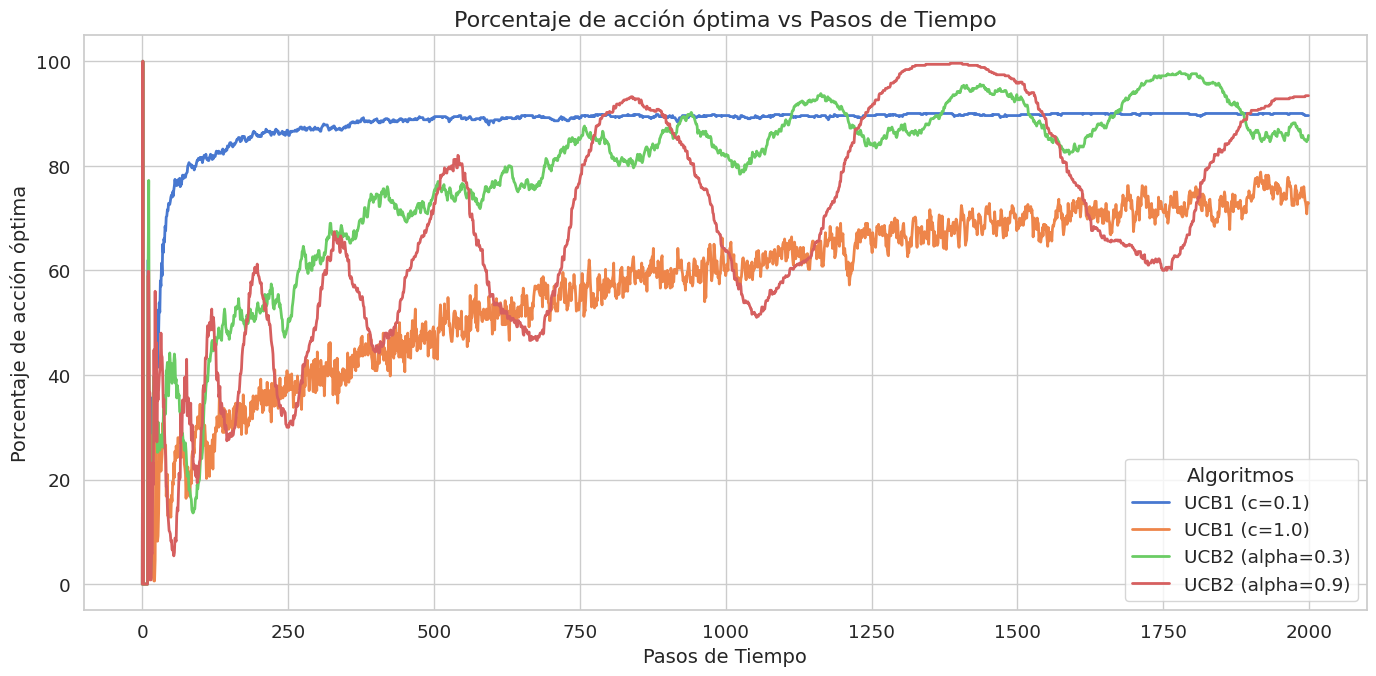

In [15]:
plot_optimal_selections(steps, optimal_selections, algorithms)

**ANÁLISIS DETALLADO DE LA IMAGEN**

La imagen muestra un gráfico de líneas titulado **"Porcentaje de acción óptima vs Pasos de Tiempo"**, donde se compara el rendimiento de distintas configuraciones de los algoritmos **UCB1** y **UCB2**. En el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el **porcentaje de veces que se selecciona la acción óptima**.

**1. Interpretación de las líneas del gráfico**

En la gráfica aparecen cuatro curvas, cada una asociada a una configuración distinta:

- **Azul (UCB1 con $c = 0.1$):** Representa una estrategia con exploración baja (explotadora), donde el algoritmo explora alternativas pero prioriza las acciones que ya han demostrado buen rendimiento.  
- **Naranja (UCB1 con $c = 1.0$):** Representa una estrategia más exploradora, ya que un valor alto de $c$ incrementa el peso del término de exploración.  
- **Verde (UCB2 con $\alpha = 0.3$):** Estrategia con exploración moderada dentro del esquema basado en épocas característico de UCB2.  
- **Roja (UCB2 con $\alpha = 0.9$):** Estrategia altamente exploradora, donde se favorece probar brazos menos seleccionados.


**2. Evolución del porcentaje de acción óptima**

Al igual que ocurrió con la gráfica anterior, todas las configuraciones muestran un aumento progresivo en el porcentaje de selección de la acción óptima, lo que indica aprendizaje efectivo del mejor brazo.

Sin embargo, existen diferencias claras en:

- Velocidad con la que se identifica la acción óptima  
- Estabilidad de la selección  
- Oscilaciones provocadas por la exploración continua  

**UCB1 ($c = 0.1$) — Línea azul**

Esta configuración muestra el crecimiento más rápido hacia valores altos. Tras una fase inicial muy corta, el algoritmo alcanza aproximadamente un $90\%$ de selección de la acción óptima y se mantiene muy estable hasta el final.

Esto indica que el nivel de exploración es suficiente para identificar el mejor brazo sin penalizar en exceso la explotación posterior.

**UCB1 ($c = 1.0$) — Línea naranja**

Presenta un crecimiento mucho más lento. Durante los primeros pasos el porcentaje de selección óptima es bajo debido a la exploración intensiva.

A lo largo del experimento mejora progresivamente, pero se mantiene claramente por debajo del resto, estabilizándose aproximadamente entre el $70\%$ y el $75\%$. Esto sugiere que el algoritmo continúa explorando incluso cuando ya tiene buena información del entorno.


**UCB2 ($\alpha = 0.3$) — Línea verde**

Muestra un crecimiento progresivo relativamente sólido, alcanzando valores cercanos al $90\%$ tras varios cientos de pasos.

Presenta oscilaciones moderadas, probablemente asociadas a los cambios entre épocas del algoritmo. Sin embargo, mantiene un buen rendimiento general, acercándose en muchos momentos al mejor comportamiento observado.

**UCB2 ($\alpha = 0.9$) — Línea roja**

Es la configuración más inestable. Presenta grandes oscilaciones a lo largo de todo el experimento, con picos cercanos al $100\%$ seguidos de caídas pronunciadas.

Esto indica una exploración muy agresiva, que provoca que el algoritmo abandone temporalmente el mejor brazo para explorar otros, reduciendo el porcentaje de selección óptima en ciertos intervalos.

**4. Conclusiones generales**

El gráfico refleja claramente cómo el nivel de exploración influye en la capacidad de seleccionar la acción óptima:

- Configuraciones con **exploración moderada** alcanzan rápidamente valores altos y se mantienen estables.  
- Configuraciones con **exploración excesiva** presentan oscilaciones grandes y menor porcentaje medio de selección óptima.  
- Un equilibrio adecuado entre exploración y explotación es clave para maximizar el rendimiento.
- La naturalexa de UCB2, que usa épocas, hace que sus gráficas muestren ciertas ondulaciones, sobre todo con valores de alpha más altos.

En este experimento, la configuración que ofrece el comportamiento más sólido es UCB1 con un nivel moderado de exploración, ya que consigue identificar rápidamente la acción óptima y mantener una selección estable durante todo el proceso.






### Arrepentimiento acumulado vs pasos de tiempo

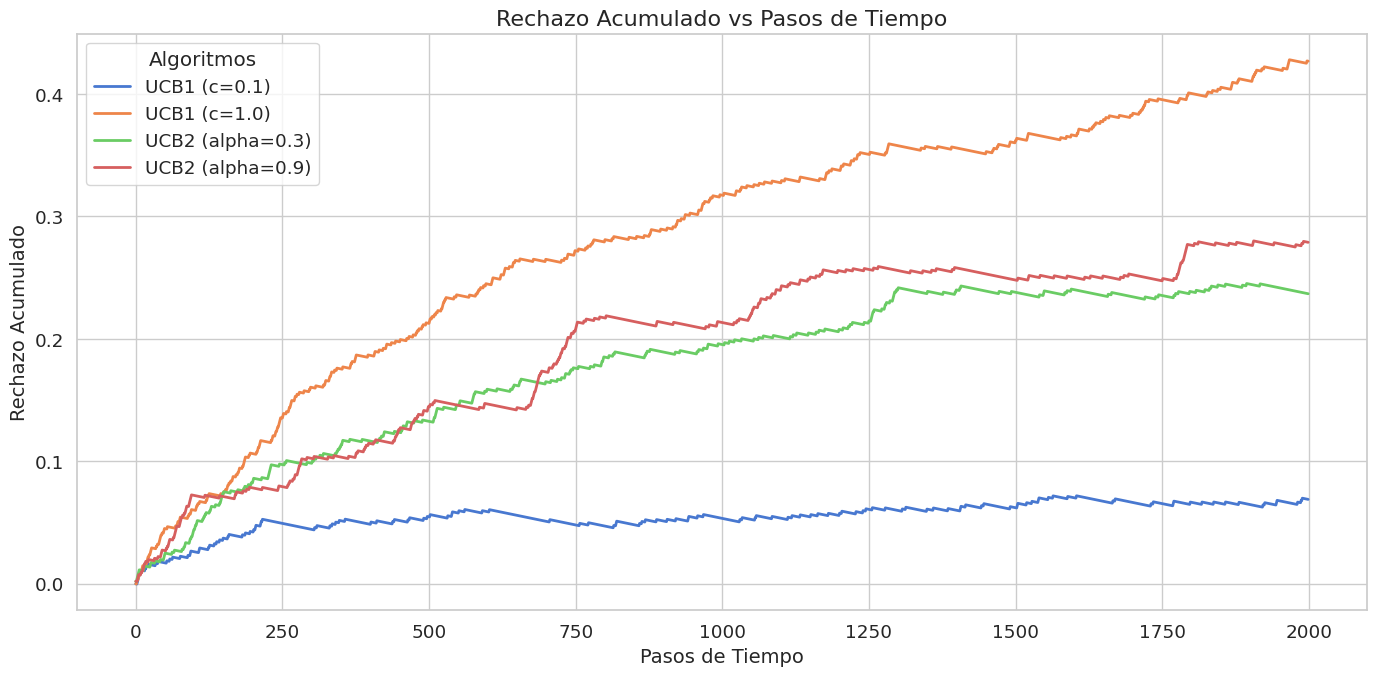

In [11]:
plot_regret(steps, regrets, algorithms)

**ANÁLISIS DETALLADO DE LA IMAGEN**

La imagen muestra un gráfico de líneas titulado **"Rechazo Acumulado vs Pasos de Tiempo"**, donde se compara el rendimiento de distintas configuraciones de los algoritmos **UCB1** y **UCB2**. En el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el **rechazo acumulado**, que mide la pérdida total respecto a la recompensa que se habría obtenido seleccionando siempre la acción óptima.

### **1. Interpretación de las líneas del gráfico**

En la gráfica aparecen cuatro curvas, cada una correspondiente a una configuración distinta:

- **Azul (UCB1 con $c = 0.1$):** Representa una estrategia con exploración baja (explotadora), donde el algoritmo explora alternativas pero prioriza las acciones que ya han demostrado buen rendimiento.  
- **Naranja (UCB1 con $c = 1.0$):** Representa una estrategia más exploradora, ya que un valor alto de $c$ incrementa el peso del término de exploración.  
- **Verde (UCB2 con $\alpha = 0.3$):** Estrategia con exploración moderada dentro del esquema basado en épocas característico de UCB2.  
- **Roja (UCB2 con $\alpha = 0.9$):** Estrategia altamente exploradora, donde se favorece probar brazos menos seleccionados.

### **2. Evolución global del rechazo acumulado**

El rechazo acumulado crece con el número de pasos para todos los algoritmos, lo cual es esperable, ya que incluso los mejores algoritmos necesitan explorar en ciertas fases del aprendizaje.

Sin embargo, las diferencias entre algoritmos son claras en la pendiente de crecimiento:

- Pendientes suaves indican buen aprendizaje y rápida identificación del mejor brazo.  
- Pendientes pronunciadas indican exploración excesiva y selección frecuente de brazos subóptimos.

#### **UCB1 ($c = 0.1$) — Línea azul**

Es la curva con menor crecimiento de rechazo acumulado. Tras una fase inicial corta, el crecimiento se vuelve muy lento, manteniéndose aproximadamente por debajo de $0.07$ incluso al final del experimento.

Esto indica que el algoritmo identifica rápidamente el mejor brazo y reduce al mínimo las selecciones subóptimas.

#### **UCB1 ($c = 1.0$) — Línea naranja**

Es la curva con peor comportamiento. El rechazo acumulado crece de forma casi constante durante todo el experimento, alcanzando valores superiores a $0.4$.

Esto sugiere que el nivel de exploración es demasiado alto, provocando selecciones frecuentes de brazos con peor recompensa incluso en fases avanzadas.

#### **UCB2 ($\alpha = 0.3$) — Línea verde**

Muestra un crecimiento moderado del rechazo acumulado. Aunque es mayor que en UCB1 con baja exploración, se mantiene relativamente controlado, situándose cerca de $0.24$ al final del experimento.

Presenta pequeños cambios de pendiente que pueden estar relacionados con el funcionamiento por épocas del algoritmo.

#### **UCB2 ($\alpha = 0.9$) — Línea roja**

Presenta un comportamiento intermedio entre UCB1 con alta exploración y UCB2 con exploración moderada. El rechazo acumulado crece de forma irregular, con tramos de crecimiento rápido seguidos de estabilización.

Esto refleja la exploración agresiva característica de valores altos de $\alpha$.

### **4. Conclusiones generales**

El gráfico muestra claramente el impacto del nivel de exploración sobre el rechazo acumulado:

- Estrategias con **exploración moderada** minimizan la pérdida acumulada.  
- Estrategias con **exploración excesiva** generan pérdidas sostenidas a lo largo del tiempo.  
- Un buen equilibrio exploración-explotación es clave para minimizar el rechazo acumulado.

En este experimento, la configuración con mejor rendimiento global es UCB1 con exploración moderada, ya que consigue mantener el rechazo acumulado en valores muy bajos durante todo el proceso.


## **Conclusiones**

En este estudio hemos analizado un **problema de toma de decisiones secuenciales** modelado mediante un **Multi-Armed Bandit (MAB)**, un marco fundamental dentro del aprendizaje por refuerzo y la teoría de decisión. En este contexto, un agente debe aprender qué acción maximiza la recompensa únicamente a partir de la experiencia obtenida durante la interacción con el entorno.

En este experimento se han evaluado distintas configuraciones de los algoritmos **UCB1** y **UCB2**, comparando su comportamiento mediante varias métricas: recompensa promedio, porcentaje de selección de acción óptima y rechazo acumulado.

### **1. Exploración vs Explotación**

Los algoritmos UCB implementan el equilibrio entre exploración y explotación mediante un **límite superior de confianza**, que combina la recompensa media estimada con un término que favorece acciones poco exploradas.

Los resultados observados en las gráficas muestran claramente este equilibrio:

- Configuraciones con **exploración moderada** (como $c=0.1$ en UCB1 o $\alpha=0.3$ en UCB2) logran un equilibrio muy eficiente.
- Configuraciones con **exploración alta** (como $c=1$ o $\alpha=0.9$) tienden a probar más brazos subóptimos, lo que penaliza el rendimiento en varias métricas.

Esto se refleja en:

- Mayor estabilidad en la recompensa promedio.
- Mayor porcentaje sostenido de selección de la acción óptima.
- Menor crecimiento del rechazo acumulado.

### **2. Análisis conjunto de las métricas**

#### **Recompensa Promedio**

Los algoritmos con exploración moderada alcanzan rápidamente valores cercanos al óptimo y se mantienen estables.  
Las configuraciones altamente exploradoras presentan más oscilaciones y tardan más en estabilizarse.

#### **Porcentaje de Acción Óptima**

Se observa que:

- Las estrategias con exploración moderada alcanzan rápidamente valores cercanos al $90\%$.
- Las estrategias muy exploradoras presentan grandes oscilaciones y menor porcentaje medio a largo plazo.

Esto indica que explorar demasiado puede impedir explotar de forma consistente el mejor brazo.

#### **Rechazo Acumulado**

Esta métrica refuerza las conclusiones anteriores:

- Exploración moderada → crecimiento lento del rechazo acumulado.
- Exploración alta → crecimiento continuo y pronunciado del rechazo.

Especialmente, la configuración con exploración moderada mantiene valores de pérdida muy reducidos incluso tras muchos pasos de aprendizaje.

### **3. Velocidad de Convergencia**

Los resultados muestran que:

- Las configuraciones con exploración moderada identifican rápidamente el mejor brazo.
- Las configuraciones con exploración alta siguen explorando incluso cuando ya existe suficiente información.
- La falta de exploración total puede ser peligrosa en otros algoritmos, pero en UCB siempre existe un mecanismo mínimo de exploración controlada.

### **4. Interpretación práctica**

En problemas reales de toma de decisiones, como:

- Sistemas de recomendación  
- Optimización de publicidad  
- Selección de tratamientos médicos  
- Optimización de recursos  

Un equilibrio adecuado entre exploración y explotación es fundamental para maximizar el rendimiento a largo plazo.

Los resultados sugieren que una exploración moderada permite:

- Aprender rápido cuál es la mejor opción.
- Mantener resultados estables.
- Minimizar pérdidas acumuladas.


### **5. Conclusión Final**

El análisis conjunto de todas las métricas confirma que el rendimiento óptimo no se obtiene ni con exploración nula ni con exploración excesiva, sino con un **equilibrio adecuado entre ambas**.

En este experimento, las configuraciones con exploración moderada muestran el mejor comportamiento global, combinando:

- Alta recompensa promedio  
- Alto porcentaje de selección de acción óptima  
- Bajo rechazo acumulado  

En definitiva, los resultados demuestran que un control adecuado del nivel de exploración permite mejorar significativamente el aprendizaje y la toma de decisiones en entornos de aprendizaje por refuerzo.
